# Theoretical background

In this notebook, we will fit a MSA to a Pott's model using the trained MSA Transformer (reference below), an AI tool developed to maximize the retrieval of **coevolution contacts from a shallow yet highly diverse MSA**. In practice, this module performs as well as a vanilla fitting to a Pott's model or the ESM-1b protein language model with an **MSA of only 16 sequences**, and increasing the diversity and number of these seequences only improves beyond those results.

In this notebook we will:
- Download and view the structure and sequence of *T. hennahi* myohemerithryn, deposited in the PDB. In principle this can be done with any other PDB or protein sequence and model from Alphafold2.
- Search for similar sequences to your target in the Colabfold database and retrieve its MSA. This could be done for any sequence you are interested in.
- Predict the coevolutionary contacts in your MSA and compare them with the structural contacts.
-Perform a simulated annealing simulation in Gō-Models (alpha-Carbon structure based model) considering the radius of interaction independent of the protein sequence (no sidechain effect on the prediction).
-Compare the results from the simulation and the original PDB structure (or your model).

Rao, R.M., Liu, J., Verkuil, R., Meier, J., Canny, J., Abbeel, P., Sercu, T. &amp; Rives, A.. (2021). MSA Transformer. <i>Proceedings of the 38th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 139:8844-8856 Available from https://proceedings.mlr.press/v139/rao21a.html.



### Setup (Colab)

If in colab, you will need to install these dependencies, download this data, and the model weights. If you are not in colab, you may have some of these already installed, or may need to install other dependencies (e.g. pytorch).

### Install dependencies

In [ ]:
!python -m pip install biopython biotite py3Dmol
!python -m pip install git+https://github.com/facebookresearch/esm.git
!apt-get install aria2

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-tzrpjt1d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-tzrpjt1d
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


### Download model weights
This download code is technically unnecessary. ESM will download weights automatically. However, it's *really* slow on colab. aria2c is much faster.

In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt


10/20 16:27:28 [NOTICE] Downloading 1 item(s)

10/20 16:27:45 [NOTICE] Download complete: /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
209e54|OK  |   154MiB/s|/root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt

Status Legend:
(OK):download completed.

10/20 16:27:45 [NOTICE] Downloading 1 item(s)

10/20 16:27:45 [NOTICE] Download complete: /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
96b043|OK  |   514KiB/s|/root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt

Status Legend:
(OK):download completed.

10/20 16:27:45 [NOTICE] Downloading 1 item(s)

10/20 16:27:45 [NOTICE] GID#4a52c4b7303140ff - Download has already completed: /root/.cache/torch/hub/chec

## Imports

In [ ]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdb import PDBFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

## Define Functions

### Parsing alignments

In [ ]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 8 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [ ]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))

    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Subsampling MSA

In [ ]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Compute contact precisions

In [ ]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [ ]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Get the your protein MSA and structure from databases

1. We can retrieve our sequence from the Myohemerythrin structure in the PDB:

In [ ]:
import os
from pathlib import Path
from Bio import SeqIO, Entrez
seqlist = ['2MHR_A']
for n in seqlist:
  Entrez.email = 'your.email@uc.cl'
  temp = Entrez.efetch(db="protein",rettype="fasta",id=n)
  aaseq_out = open("2mhr.fasta",'w')
  aaseq = SeqIO.read(temp, format="fasta")
  SeqIO.write(aaseq,aaseq_out,"fasta")
  temp.close()
  aaseq_out.close()

2. We will also need a structure to compare how well did the protocol predicted our contacts, this has to be in the mmCif format:

In [ ]:
from Bio.PDB import PDBList, MMCIFParser, Selection
# Specify the PDB ID
pdb_id = "2MHR"
# Download the mmCIF file for the specified PDB ID
pdb_list = PDBList()
mmcif_file = pdb_list.retrieve_pdb_file(pdb_id, file_format="mmCif")
# Parse the mmCIF file
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, mmcif_file)
# Define a function to filter out non-protein residues (e.g., water and ions)
def is_protein(atom):
    return atom.get_parent().get_full_id()[3][0] == ' '
# Create a new structure containing only the protein atoms
protein_structure = Selection.unfold_entities(structure, 'A')
# Filter the structure to include only protein atoms
protein_structure = [atom for atom in protein_structure if is_protein(atom)]
# Now, protein_structure contains only the protein atoms, excluding water and ions
!mv /content/mh/2mhr.cif /content/2mhr.cif

3. Let's see the myohemerytrhin structure:

In [ ]:
import py3Dmol
#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('2mhr.cif', 'r').read(),'mmCif')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'chain':'A'},{'cartoon': {'colorscheme':'ssJmol'}})
#You can activate the labels for each residue if you want
#or comment them with a '#' at the beggining of each line if you do not want to
view.addResLabels({'resi':'1'},{'fontColor':'white','fontOpacity':1,'showBackground':'true'})
view.addResLabels({'resi':'118'},{'fontColor':'white','fontOpacity':1,'showBackground':'true'})

#Here we center the molecule for its visualization
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

4. For the MSA, we will do a search with MMSEQS2 in the Colabfold database, one of the biggest out there.

In [ ]:
%%time
#@title Setup Colabfold search
unified_memory = True #@param {type:"boolean"}
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

installing ColabDesign
installing HHsuite
downloading AlphaFold params
CPU times: user 1.65 s, sys: 219 ms, total: 1.86 s
Wall time: 1min 50s


5. Now let's print the PDB sequence to use it as input in the colabfold database search.

In [ ]:
!cat 2mhr.fasta

>pdb|2MHR|A Chain A, MYOHEMERYTHRIN
GWEIPEPYVWDESFRVFYEQLDEEHKKIFKGIFDCIRDNSAPNLATLVKVTTNHFTHEEA
MMDAAKYSEVVPHKKMHKDFLEKIGGLSAPVDAKNVDYCKEWLVNHIKGTDFKYKGKL


jobname 2mhr
length=[118] copies=1
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 01:01 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


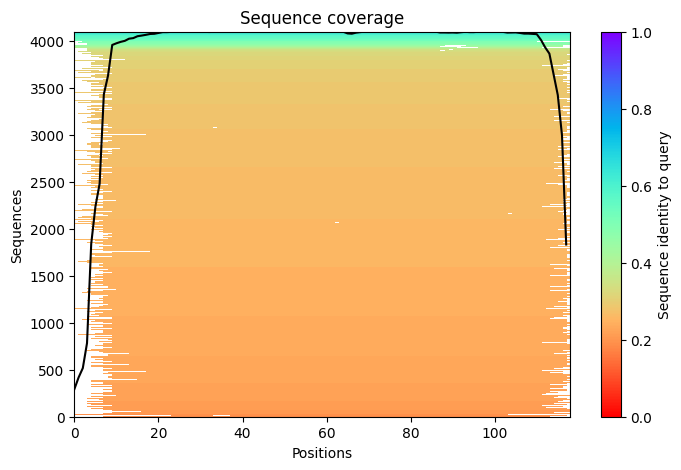

GC 6015


In [ ]:
#@title Colabfold input
sequence = "GWEIPEPYVWDESFRVFYEQLDEEHKKIFKGIFDCIRDNSAPNLATLVKVTTNHFTHEEAMMDAAKYSEVVPHKKMHKDFLEKIGGLSAPVDAKNVDYCKEWLVNHIKGTDFKYKGKL" #@param {type:"string"}
jobname = "2mhr" #@param {type:"string"}

copies = 1
#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown filtering options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 0 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}

#@markdown ----
template_mode = "none"
use_templates = template_mode in ["mmseqs2","custom"]
pdb = ""
chain = "A"
rm_template_seq = False
propagate_to_copies = True
rm_interchain = False
do_not_align = False
rm_sidechain = rm_sequence = rm_template_seq

# filter options
sequence = sequence.upper()
sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
sequence = re.sub("\(",":(", sequence)
sequence = re.sub("\)","):", sequence)
sequence = re.sub(":+",":",sequence)
sequence = re.sub("/+","/",sequence)
sequence = re.sub("^[:/]+","",sequence)
sequence = re.sub("[:/]+$","",sequence)
jobname = re.sub(r'\W+', '', jobname)

# process sequence
sequences = sequence.split(":")
u_sequences = predict.get_unique_sequences(sequences)
u_cyclic = [x.startswith("(") for x in u_sequences]
u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
if len(sequences) > len(u_sequences):
  print("WARNING: use copies to define homooligomers")
u_lengths = [len(x) for x in u_sequences]
sub_seq = "".join(u_sequences)
seq = sub_seq * copies

print("jobname",jobname)
print(f"length={u_lengths} copies={copies}")

input_opts = {"sequence":u_sequences,
              "copies":copies,
              "msa_method":msa_method,
              "pair_mode":pair_mode,
              "do_not_filter":do_not_filter,
              "cov":cov,
              "id":id,
              "template_mode":template_mode,
              "propagate_to_copies":propagate_to_copies}

##################
# GET MSA
##################
#os.makedirs(jobname, exist_ok=True)

Ls = [len(x) for x in u_sequences]
if msa_method == "mmseqs2":
  msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
    mode=pair_mode,
    cov=cov, id=id, qid=qid, max_msa=4096,
    do_not_filter=do_not_filter,
    mmseqs2_fn=lambda *x: run_mmseqs2(*x, user_agent="colabdesign/gamma"),
    hhfilter_fn=run_hhfilter)
!mv {jobname}/msa.a3m {jobname}.a3m
!rm -r {jobname}/
if len(msa) > 1:
  predict.plot_msa(msa, Ls)
  plt.savefig(f"{jobname}_msa.png", dpi=200, bbox_inches='tight')
  plt.show()
print("GC",gc.collect())

## Predict and Visualize

### Read Data

In [ ]:
# This is where the data is actually read in
PDB_IDS = ["2mhr"]

structures = {
    name.lower(): get_structure(PDBFile.read(rcsb.fetch(name, "pdb")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

### MSA Transformer Predictions

In [ ]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [ ]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    inputs = greedy_select(inputs, num_seqs=128) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,2mhr,MSA Transformer (Unsupervised),0.75061,0.788136,0.728814,0.652174,0.256563,0.110169,0.186441,0.434783,0.457506,0.228814,0.38983,0.782609,0.733308,0.525424,0.745763,0.913043


6. Now we write the **top L** contact predictions into a file.
  These contacts will be used to define **non-bonded attractive interactions betweeen residue pairs** in our SBM.

In [ ]:
out = open("predictions.txt","w")
name = PDB_IDS[0]

prediction = msa_transformer_predictions[name]
target = contacts[name]
matrix = prediction.reshape(-1, prediction.shape[-1])
for i in range (0,len(matrix[0])):
  for j in range (i+1,len(matrix[0])):
    out.write(str(i+1)+" "+str(j+1)+" "+str(matrix[i][j]).replace("tensor(","").replace(")","")+"\n")
out.close
#Now we print the top 118 predictions
!sort -grk3 predictions.txt | awk '$1+2<$2' | head -n 118 > predictions_topl.txt
!head -n 10 predictions_topl.txt

16 22 1.0000
90 95 0.9999
59 74 0.9999
15 22 0.9999
12 15 0.9999
90 94 0.9998
65 117 0.9998
62 67 0.9998
24 57 0.9998
44 88 0.9997


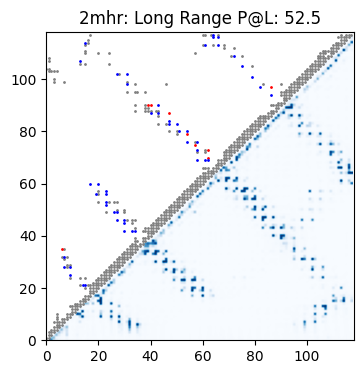

In [ ]:
import matplotlib.pyplot as plt
name = PDB_IDS[0]

prediction = msa_transformer_predictions[name]
target = contacts[name]

fig, ax = plt.subplots(figsize=(5, 4))

plot_contacts_and_predictions(
    prediction, target, ax=ax, title=lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
)

plt.show()

## Now its just GROMACS simulations

SBM are based on the treatment of **native contacts**, i.e. pairs of residues that fall below a distance cutoff in a given protein structure, as **attractive non-bonded interactions through either Lennard-Jones or Gaussian potentials**, whereas all other non-native interactions are treated as repulsive.

In this context, **the use of physical interactions between residue pairs inferred by DCA** instead of experimentally defined native contacts is a natural extension to SBM, due to the simplicity of its attractive component in the energy function.

Here, we will use our predicted contacts, along with bonded potentials (bonds, angles and dihedrals) drawn based on secondary structure predictions using **Jpred4**, to generate an SBM that enables protein folding simulations to predict the structure of *T. hennahi* myohemerythrin based on sequence information alone.

**NOTE❗️** While the details of sequence-based secondary structure prediction are outside the scope of this tutorial, a good primer is found in the following publication:

- Rost, B. (2001). Protein secondary structure prediction continues to rise. Journal of structural biology, 134(2-3), 204-218.

We first download the precompiled GROMACS that we are going to use.

In [ ]:
# Download and unzip the compressed folder of SBM-enhanced GROMACS
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs_sbm.tar.gz
!tar xzf gromacs_sbm.tar.gz

--2024-10-20 16:38:56--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs_sbm.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23608271 (23M) [application/octet-stream]
Saving to: ‘gromacs_sbm.tar.gz’

gromacs_sbm.tar.gz  100%[===================>]  22.51M  --.-KB/s    in 0.07s   

2024-10-20 16:38:58 (328 MB/s) - ‘gromacs_sbm.tar.gz’ saved [23608271/23608271]



1. We will also need a secondary struture prediction to generate the **bonded interactions** of our SBM. For this, we will visit the [Jpred4 webserver](http://www.compbio.dundee.ac.uk/jpred/index.html), input our sequence in the text box and click on **`Make a Prediction`**, confirm that you still want to make a prediction by clicking on **`Continue`** and then select to **`View simple results in HTML`**.

  Then, load the first and second lines of the results obtained by Jpred4 in the following text box.

In [ ]:
#@title Enter the amino acid sequence and predicted secondary structure of your protein
sequence = 'GWEIPEPYVWDESFRVFYEQLDEEHKKIFKGIFDCIRDNSAPNLATLVKVTTNHFTHEEAMMDAAKYSEVVPHKKMHKDFLEKIGGLSAPVDAKNVDYCKEWLVNHIKGTDFKYKGKL'  #@param {type:"string"}
Jpred = '------------------HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH---'  #@param {type:"string"}
f = open("Jpred.txt", "a")
f.write(sequence+"\n")
f.write(Jpred)
f.close()

2. The tertiary contacts inferred by DCA and the secondary structure predicted by Jpred4 will now be used to generate our SBM using the script below. The result from this script are:
- A **coordinate** file (extension **.gro**), where each residue of the target sequence is represented by a single bead and given initial positions for starting our folding simulations.
- A **topology** file (extension **.top**), which contains the non-bonded interactions from the DCA contacts as Gaussian potentials and the bonded interactions (bonds, angles, dihedrals) drawn from the secondary structure prediction as harmonic potentials.

  Upon executing this script, you will be asked to indicate a `DCA maximum force factor`, which controls the force of pairwise potentials that will drive protein folding. A good estimate for the strength of coevolutionary interactions is to consider the force factor equivalent to the ratio of $L$ over the number of DCA pairs (factor = $L$/$|$DCA$|$). Thus, **we will use a value of 1.**

Now we download the scripts for generating the topology, coordinates and instructions for simulations.

In [ ]:
#Downloading all required files
!wget https://github.com/pb3lab/ibm3202/raw/master/scripts/dcasbm.py
!wget https://github.com/pb3lab/ibm3202/raw/master/scripts/distavg
!wget https://github.com/pb3lab/ibm3202/raw/master/files/sbm_calpha_SA_v5_short.mdp

--2024-10-20 16:39:37--  https://github.com/pb3lab/ibm3202/raw/master/scripts/dcasbm.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pb3lab/ibm3202/master/scripts/dcasbm.py [following]
--2024-10-20 16:39:37--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/scripts/dcasbm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7407 (7.2K) [text/plain]
Saving to: ‘dcasbm.py’

dcasbm.py           100%[===================>]   7.23K  --.-KB/s    in 0s      

2024-10-20 16:39:37 (81.2 MB/s) - ‘dcasbm.py’ saved [7407/7407]

--2024-10-20 16:39:37--  https://github.com/pb3lab/ibm3202/raw/maste

Then, we generate the topology

In [ ]:
!python dcasbm.py Jpred.txt predictions_topl.txt


	DCA maximum force factor: 1

	Protein sequence in selected file:
	GWEIPEPYVWDESFRVFYEQLDEEHKKIFKGIFDCIRDNSAPNLATLVKVTTNHFTHEEAMMDAAKYSEVVPHKKMHKDF

	Total number of residues: 118

	A protein coordinates file was saved in this folder as Jpred_calpha.gro

	A protein topology file was saved in this folder as Jpred_calpha.top



3. Lastly, we will use our coordinate and topology files along with a parameter file to set up and run a folding simulation in our SBM-enhanced version of GROMACS.

  These simulations start at a high temperature in which the protein is unfolded, and then the system temperature is gradually reduced until the protein reaches an energy minimum where most interactions are satisfied.

In [ ]:
%%time
%%bash
source /content/gromacs_sbm/bin/GMXRC
#Preparing the binary input for our folding simulation file
gmx grompp -f sbm_calpha_SA_v5_short.mdp -c Jpred_calpha.gro -p Jpred_calpha.top -o run.tpr
#Running our folding simulation
gmx mdrun -deffnm run -nt 1 -noddcheck

Analysing residue names:
There are:   118    Protein residues
Analysing Protein...
This run will generate roughly 4 Mb of data


GROMACS:    gmx grompp, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or m

CPU times: user 620 ms, sys: 85.8 ms, total: 706 ms
Wall time: 2min 20s


4. We will now convert our final .gro structure into a PDB file for further comparison with the experimental structure of *T. hennahi* myohemerythrin

In [ ]:
%%bash
source /content/gromacs_sbm/bin/GMXRC
#Converting our final structure from .gro into a PDB file
gmx editconf -f run.gro -o predicted.pdb

Read 118 atoms
Volume: 103382 nm^3, corresponds to roughly 46521900 electrons
Velocities found


GROMACS:    gmx editconf, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or

5. Once our folding simulation is complete and we have converted our final coordinates onto the PDB file format, we can compare the predicted structure based on sequence information alone with the experimentally determined structure of *T. hennahi* myohemerythrin. For this, we will first perform a structural alignment of both structures.

  In the following box, please enter the filename of the experimental structure (including its .pdb extension) and indicate the starting and ending residues that you wish to align (e.g. 1 to 118)
  
**NOTE❗️** Remember that, typically, the N- and C-termini of a protein structure are very flexible and can be disregarded from the structural alignment to obtain better results.

### Getting the 2MHR chain A structure

In [ ]:
from Bio.PDB import PDBList, PDBParser, PDBIO, Select

# Specify the PDB ID and chain you want to download
pdb_id = "2MHR"
chain_id = "A"

# Define a custom Select class to filter protein atoms
class ProteinSelector(Select):
    def accept_chain(self, chain):
        return chain.get_id() == chain_id

    def accept_residue(self, residue):
        return residue.get_id()[0] == ' '

# Download the PDB file for the specified PDB ID
pdb_list = PDBList()
pdb_file = pdb_list.retrieve_pdb_file(pdb_id, file_format="pdb")

# Parse the PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, pdb_file)

# Apply the custom selection to keep only protein atoms
io = PDBIO()
io.set_structure(structure)
io.save("experimental.pdb", select=ProteinSelector())

In [ ]:
#@title Perform a structural alignment between the predicted and experimental structure

import Bio.PDB

# Select what residues numbers you wish to align
# and put them in a list

#@markdown A. Indicate the starting and ending residues you wish to align

start_resi = 17 #@param {type:"number"}
end_resi   = 118 #@param {type:"number"}
atoms_to_be_aligned = range(start_resi, end_resi + 1)

# Start the parser
pdb_parser = Bio.PDB.PDBParser(QUIET = True)

#@markdown B. Indicate the filename of the experimental structure (PDB file)

# Get the structures
experimental = 'experimental.pdb' #@param {type:"string"}
predicted = 'predicted.pdb'
ref_structure = pdb_parser.get_structure("reference", experimental)
sample_structure = pdb_parser.get_structure("sample", predicted)

# Use the first model in the pdb-files for alignment
# Change the number 0 if you want to align to another structure
ref_model    = ref_structure[0]
sample_model = sample_structure[0]

# Make a list of the atoms (in the structures) you wish to align.
# In this case we use CA atoms whose index is in the specified range
ref_atoms = []
sample_atoms = []

# Iterate of all chains in the model in order to find all residues
for ref_chain in ref_model:
  # Iterate of all residues in each model in order to find proper atoms
  for ref_res in ref_chain:
    # Check if residue number ( .get_id() ) is in the list
    if ref_res.get_id()[1] in atoms_to_be_aligned:
      # Append CA atom to list
      ref_atoms.append(ref_res['CA'])

# Do the same for the sample structure
for sample_chain in sample_model:
  for sample_res in sample_chain:
    if sample_res.get_id()[1] in atoms_to_be_aligned:
      sample_atoms.append(sample_res['CA'])

# Now we initiate the superimposer:
super_imposer = Bio.PDB.Superimposer()
super_imposer.set_atoms(ref_atoms, sample_atoms)
super_imposer.apply(sample_model.get_atoms())

# Print RMSD:
print('The calculated RMSD is:')
print (super_imposer.rms)

# Save the aligned version of one of the chains of 6ANE
io = Bio.PDB.PDBIO()
io.set_structure(sample_structure)
io.save("predicted_aligned.pdb")

aligned = 'predicted_aligned.pdb'

The calculated RMSD is:
3.163738084051553


6. Now we can load the superimposed structure into py3dmol with the code cell shown below to visualize the accuracy of our prediction.

**QUESTION❓**
- How accurate was your prediction when compared to the experimentally solved structure of *T. hennahi* myohemerythrin?
- In which ways do you believe that the accuracy of your prediction can be improved?

In [ ]:
import py3Dmol
view=py3Dmol.view()
view.addModel(open(experimental, 'r').read(),'pdb')
view.setStyle({'chain':'A'},{'cartoon': {'color':'spectrum'}})
view.addModel(open(aligned, 'r').read(),'pdb')
view.setStyle({'chain':' '},{'cartoon': {'style':'trace','color':'red'}})
#You can opt to delete these labels
view.addResLabels({'resi':'1'},{'fontColor':'white','fontOpacity':1,'showBackground':'true'})
view.addResLabels({'resi':'118'},{'fontColor':'white','fontOpacity':1,'showBackground':'true'})

view.zoomTo()
view.setBackgroundColor('white')
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.